## 分析課題

背景<br>
・事業者Aはコンビニチェーンを営んでおり、店舗独自のポイントカードを発行している<br>
・弁当（和風および洋風）の製造方法を含め、様々な商品リニューアルを行なった

課題<br>
・実際の分析コンサルティング業務を想定して、POSデータを用いた当リニューアルの効果について論じなさい

## モジュール

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy import stats
from statistics import mean, variance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

## 1. データセット

In [2]:
user_mst = pd.read_csv('user_mst.csv')

print(user_mst.shape)
user_mst.head(10)

(2097, 2)


,user_id,shop_flg
0,34860083,0
1,45587843,0
2,0,0
3,54852497,0
4,23543782,0
5,20061194,0
6,29213200,0
7,65981004,0
8,49720208,0
9,41169191,0


・ポイントカードを使用していないユーザーは、user_idが0になる<br>
・店舗アカウントで処理された購入履歴（shop_flg: 1）は、売上集計や購入個数集計の対象外となる

In [3]:
purchase_log = pd.read_csv('purchase_log.csv')

print(purchase_log.shape)
purchase_log.head(10)

(31130, 5)


,receipt_no,user_id,item_id,unit,date_jst
0,5307465824,34860083,s_00001,1.0,2020-10-04 00:06:47
1,5307465824,34860083,s_00004,1.0,2020-10-04 00:06:47
2,5307465825,45587843,s_00001,1.0,2020-10-04 00:12:54
3,5307465826,0,s_00002,1.0,2020-10-04 00:15:01
4,5307465826,0,s_00003,1.0,2020-10-04 00:15:01
5,5307465827,0,s_00005,1.0,2020-10-04 00:17:52
6,5307465828,54852497,s_00005,1.0,2020-10-04 00:22:12
7,5307465829,23543782,s_00001,1.0,2020-10-04 00:23:55
8,5307465830,20061194,s_00005,1.0,2020-10-04 00:26:17
9,5307465831,29213200,s_00002,1.0,2020-10-04 00:29:21


・ポイントカードを使用していないユーザーは、user_idが0になる

In [4]:
item_mst = pd.read_csv('item_mst_UTF-8.csv')

print(item_mst.shape)
item_mst.head(10)

(8, 7)


,item_id,item_name,category_1,category_2,category_3,amount,unit_price
0,s_00001,弁当（和風）,食料,冷蔵,弁当,600,500
1,s_00002,弁当（洋風）,食料,冷蔵,弁当,700,550
2,s_00003,おにぎり（うめぼし）,食料,冷蔵,おにぎり,100,130
3,s_00004,唐揚げ,食料,ホットスナック,揚げ物,160,250
4,s_00005,ミネラルウォーター500ml,食料,ドリンク,水,500,150
5,s_00006,弁当（和風）,食料,冷蔵,弁当,500,420
6,s_00007,弁当（洋風）,食料,冷蔵,弁当,850,750
7,s_00008,カフェラテ,食料,ドリンク,コーヒー,250,200


・弁当（和風）と弁当（洋風）が2つずつあるので、これらはリニューアル前と後の商品であることが分かる

In [5]:
purchase_log['date'] = pd.to_datetime(purchase_log['date_jst'], format='%Y-%m-%d').dt.date

purchase_log['date'] = pd.to_datetime(purchase_log['date'])
purchase_log['date_jst'] = pd.to_datetime(purchase_log['date_jst'])

print(purchase_log.dtypes)
purchase_log.head()

receipt_no             int64
user_id                int64
item_id               object
unit                 float64
date_jst      datetime64[ns]
date          datetime64[ns]
dtype: object


,receipt_no,user_id,item_id,unit,date_jst,date
0,5307465824,34860083,s_00001,1.0,2020-10-04 00:06:47,2020-10-04
1,5307465824,34860083,s_00004,1.0,2020-10-04 00:06:47,2020-10-04
2,5307465825,45587843,s_00001,1.0,2020-10-04 00:12:54,2020-10-04
3,5307465826,0,s_00002,1.0,2020-10-04 00:15:01,2020-10-04
4,5307465826,0,s_00003,1.0,2020-10-04 00:15:01,2020-10-04


In [6]:
df = pd.merge(item_mst, purchase_log, on='item_id', how='left')
df = pd.merge(df, user_mst, on='user_id', how='left')

print(df.shape)
df.head(10)

(31131, 13)


,item_id,item_name,category_1,category_2,category_3,amount,unit_price,receipt_no,user_id,unit,date_jst,date,shop_flg
0,s_00001,弁当（和風）,食料,冷蔵,弁当,600,500,5.307466e+09,34860083.0,1.0,2020-10-04 00:06:47,2020-10-04,0.0
1,s_00001,弁当（和風）,食料,冷蔵,弁当,600,500,5.307466e+09,45587843.0,1.0,2020-10-04 00:12:54,2020-10-04,0.0
2,s_00001,弁当（和風）,食料,冷蔵,弁当,600,500,5.307466e+09,23543782.0,1.0,2020-10-04 00:23:55,2020-10-04,0.0
3,s_00001,弁当（和風）,食料,冷蔵,弁当,600,500,5.307466e+09,65981004.0,1.0,2020-10-04 00:29:56,2020-10-04,0.0
4,s_00001,弁当（和風）,食料,冷蔵,弁当,600,500,5.307466e+09,0.0,1.0,2020-10-04 00:40:40,2020-10-04,0.0
5,s_00001,弁当（和風）,食料,冷蔵,弁当,600,500,5.307466e+09,49720208.0,1.0,2020-10-04 00:46:08,2020-10-04,0.0
6,s_00001,弁当（和風）,食料,冷蔵,弁当,600,500,5.307466e+09,0.0,1.0,2020-10-04 00:47:29,2020-10-04,0.0
7,s_00001,弁当（和風）,食料,冷蔵,弁当,600,500,5.307466e+09,0.0,1.0,2020-10-04 00:57:06,2020-10-04,0.0
8,s_00001,弁当（和風）,食料,冷蔵,弁当,600,500,5.307466e+09,93334576.0,1.0,2020-10-04 00:59:12,2020-10-04,0.0
9,s_00001,弁当（和風）,食料,冷蔵,弁当,600,500,5.307466e+09,0.0,1.0,2020-10-04 01:00:32,2020-10-04,0.0


In [7]:
df[df['shop_flg'] == 1]

,item_id,item_name,category_1,category_2,category_3,amount,unit_price,receipt_no,user_id,unit,date_jst,date,shop_flg
1388,s_00001,弁当（和風）,食料,冷蔵,弁当,600,500,9.000000e+09,99999993.0,-100.0,2020-10-15 00:00:00,2020-10-15,1.0
4671,s_00002,弁当（洋風）,食料,冷蔵,弁当,700,550,9.000000e+09,99999993.0,-100.0,2020-10-15 00:00:10,2020-10-15,1.0
6910,s_00003,おにぎり（うめぼし）,食料,冷蔵,おにぎり,100,130,9.000000e+09,99999993.0,-100.0,2020-10-15 00:00:21,2020-10-15,1.0
10295,s_00004,唐揚げ,食料,ホットスナック,揚げ物,160,250,9.000000e+09,99999992.0,-100.0,2020-10-15 00:00:04,2020-10-15,1.0
16927,s_00005,ミネラルウォーター500ml,食料,ドリンク,水,500,150,9.000000e+09,99999992.0,-100.0,2020-10-15 00:00:35,2020-10-15,1.0


In [8]:
df = df[df['shop_flg'] != 1]

print(df.shape)

(31126, 13)


In [9]:
df['earnings'] = df['unit_price'] * df['unit']
df['month'] = df['date'].dt.month

In [10]:
def renewal(x):
    if x == 500:
        y = 0
    elif x == 550:
        y = 0
    elif x == 420:
        y = 1
    elif x == 750:
        y = 1
    else:
        y = 2
    return y
        
df['renewal'] = df['unit_price'].apply(lambda x: renewal(x))

In [11]:
def point_card(x):
    if x == 0:
        y = 0
    else:
        y = 1
    return y
        
df['point_card'] = df['user_id'].apply(lambda x: point_card(x))

In [12]:
df = df.drop(['category_1', 'category_2', 'category_3', 'receipt_no'], axis=1)

print(df.shape)
df.head()

(31126, 13)


,item_id,item_name,amount,unit_price,user_id,unit,date_jst,date,shop_flg,earnings,month,renewal,point_card
0,s_00001,弁当（和風）,600,500,34860083.0,1.0,2020-10-04 00:06:47,2020-10-04,0.0,500.0,10.0,0,1
1,s_00001,弁当（和風）,600,500,45587843.0,1.0,2020-10-04 00:12:54,2020-10-04,0.0,500.0,10.0,0,1
2,s_00001,弁当（和風）,600,500,23543782.0,1.0,2020-10-04 00:23:55,2020-10-04,0.0,500.0,10.0,0,1
3,s_00001,弁当（和風）,600,500,65981004.0,1.0,2020-10-04 00:29:56,2020-10-04,0.0,500.0,10.0,0,1
4,s_00001,弁当（和風）,600,500,0.0,1.0,2020-10-04 00:40:40,2020-10-04,0.0,500.0,10.0,0,0


## 2. 前提条件

### ・データの期間

In [13]:
df.head()

,item_id,item_name,amount,unit_price,user_id,unit,date_jst,date,shop_flg,earnings,month,renewal,point_card
0,s_00001,弁当（和風）,600,500,34860083.0,1.0,2020-10-04 00:06:47,2020-10-04,0.0,500.0,10.0,0,1
1,s_00001,弁当（和風）,600,500,45587843.0,1.0,2020-10-04 00:12:54,2020-10-04,0.0,500.0,10.0,0,1
2,s_00001,弁当（和風）,600,500,23543782.0,1.0,2020-10-04 00:23:55,2020-10-04,0.0,500.0,10.0,0,1
3,s_00001,弁当（和風）,600,500,65981004.0,1.0,2020-10-04 00:29:56,2020-10-04,0.0,500.0,10.0,0,1
4,s_00001,弁当（和風）,600,500,0.0,1.0,2020-10-04 00:40:40,2020-10-04,0.0,500.0,10.0,0,0


In [14]:
df.tail()

,item_id,item_name,amount,unit_price,user_id,unit,date_jst,date,shop_flg,earnings,month,renewal,point_card
31126,s_00007,弁当（洋風）,850,750,0.0,1.0,2020-11-28 23:20:47,2020-11-28,0.0,750.0,11.0,1,0
31127,s_00007,弁当（洋風）,850,750,0.0,1.0,2020-11-28 23:26:31,2020-11-28,0.0,750.0,11.0,1,0
31128,s_00007,弁当（洋風）,850,750,0.0,1.0,2020-11-28 23:44:27,2020-11-28,0.0,750.0,11.0,1,0
31129,s_00007,弁当（洋風）,850,750,0.0,1.0,2020-11-28 23:56:29,2020-11-28,0.0,750.0,11.0,1,0
31130,s_00008,カフェラテ,250,200,NaN,NaN,NaT,NaT,NaN,NaN,NaN,2,1


・POSデータの期間は、10/4〜11/28ということが分かる

In [15]:
df[df['item_id'] == 's_00001'].tail()

,item_id,item_name,amount,unit_price,user_id,unit,date_jst,date,shop_flg,earnings,month,renewal,point_card
3563,s_00001,弁当（和風）,600,500,46859391.0,1.0,2020-10-31 22:55:14,2020-10-31,0.0,500.0,10.0,0,1
3564,s_00001,弁当（和風）,600,500,0.0,1.0,2020-10-31 23:15:39,2020-10-31,0.0,500.0,10.0,0,0
3565,s_00001,弁当（和風）,600,500,10351010.0,1.0,2020-10-31 23:19:07,2020-10-31,0.0,500.0,10.0,0,1
3566,s_00001,弁当（和風）,600,500,22620685.0,1.0,2020-10-31 23:19:24,2020-10-31,0.0,500.0,10.0,0,1
3567,s_00001,弁当（和風）,600,500,0.0,1.0,2020-10-31 23:39:39,2020-10-31,0.0,500.0,10.0,0,0


・10月末は、10/31までであることが分かる<br>

### ・リニューアル日

In [16]:
df[df['item_id'] == 's_00001'].tail()

,item_id,item_name,amount,unit_price,user_id,unit,date_jst,date,shop_flg,earnings,month,renewal,point_card
3563,s_00001,弁当（和風）,600,500,46859391.0,1.0,2020-10-31 22:55:14,2020-10-31,0.0,500.0,10.0,0,1
3564,s_00001,弁当（和風）,600,500,0.0,1.0,2020-10-31 23:15:39,2020-10-31,0.0,500.0,10.0,0,0
3565,s_00001,弁当（和風）,600,500,10351010.0,1.0,2020-10-31 23:19:07,2020-10-31,0.0,500.0,10.0,0,1
3566,s_00001,弁当（和風）,600,500,22620685.0,1.0,2020-10-31 23:19:24,2020-10-31,0.0,500.0,10.0,0,1
3567,s_00001,弁当（和風）,600,500,0.0,1.0,2020-10-31 23:39:39,2020-10-31,0.0,500.0,10.0,0,0


In [17]:
df[df['item_id'] == 's_00006'].head()

,item_id,item_name,amount,unit_price,user_id,unit,date_jst,date,shop_flg,earnings,month,renewal,point_card
24941,s_00006,弁当（和風）,500,420,81050440.0,1.0,2020-11-01 00:12:08,2020-11-01,0.0,420.0,11.0,1,1
24942,s_00006,弁当（和風）,500,420,0.0,1.0,2020-11-01 00:27:25,2020-11-01,0.0,420.0,11.0,1,0
24943,s_00006,弁当（和風）,500,420,22702677.0,1.0,2020-11-01 00:39:14,2020-11-01,0.0,420.0,11.0,1,1
24944,s_00006,弁当（和風）,500,420,13387773.0,1.0,2020-11-01 00:54:26,2020-11-01,0.0,420.0,11.0,1,1
24945,s_00006,弁当（和風）,500,420,28904597.0,1.0,2020-11-01 01:02:09,2020-11-01,0.0,420.0,11.0,1,1


In [18]:
df[df['item_id'] == 's_00002'].tail()

,item_id,item_name,amount,unit_price,user_id,unit,date_jst,date,shop_flg,earnings,month,renewal,point_card
6333,s_00002,弁当（洋風）,700,550,0.0,1.0,2020-10-31 22:23:49,2020-10-31,0.0,550.0,10.0,0,0
6334,s_00002,弁当（洋風）,700,550,0.0,1.0,2020-10-31 23:25:52,2020-10-31,0.0,550.0,10.0,0,0
6335,s_00002,弁当（洋風）,700,550,78692197.0,1.0,2020-10-31 23:31:01,2020-10-31,0.0,550.0,10.0,0,1
6336,s_00002,弁当（洋風）,700,550,0.0,1.0,2020-10-31 23:45:56,2020-10-31,0.0,550.0,10.0,0,0
6337,s_00002,弁当（洋風）,700,550,58839484.0,1.0,2020-10-31 23:58:02,2020-10-31,0.0,550.0,10.0,0,1


In [19]:
df[df['item_id'] == 's_00007'].head()

,item_id,item_name,amount,unit_price,user_id,unit,date_jst,date,shop_flg,earnings,month,renewal,point_card
29056,s_00007,弁当（洋風）,850,750,0.0,1.0,2020-11-01 00:11:57,2020-11-01,0.0,750.0,11.0,1,0
29057,s_00007,弁当（洋風）,850,750,0.0,1.0,2020-11-01 00:27:02,2020-11-01,0.0,750.0,11.0,1,0
29058,s_00007,弁当（洋風）,850,750,23360018.0,1.0,2020-11-01 00:28:42,2020-11-01,0.0,750.0,11.0,1,1
29059,s_00007,弁当（洋風）,850,750,0.0,1.0,2020-11-01 00:52:58,2020-11-01,0.0,750.0,11.0,1,0
29060,s_00007,弁当（洋風）,850,750,94278544.0,1.0,2020-11-01 01:08:33,2020-11-01,0.0,750.0,11.0,1,1


・商品のリニューアルは、11/1に行われたことが分かる<br>
・よって、リニューアル前：10/4〜10/31（28日間）と、リニューアル後：11/1〜11/28（28日間）の売上を比較すれば良い

In [20]:
df[df['item_id'] == 's_00003'].head()

,item_id,item_name,amount,unit_price,user_id,unit,date_jst,date,shop_flg,earnings,month,renewal,point_card
6338,s_00003,おにぎり（うめぼし）,100,130,0.0,1.0,2020-10-04 00:15:01,2020-10-04,0.0,130.0,10.0,2,0
6339,s_00003,おにぎり（うめぼし）,100,130,0.0,1.0,2020-10-04 00:33:50,2020-10-04,0.0,130.0,10.0,2,0
6340,s_00003,おにぎり（うめぼし）,100,130,0.0,1.0,2020-10-04 01:39:55,2020-10-04,0.0,130.0,10.0,2,0
6341,s_00003,おにぎり（うめぼし）,100,130,44480035.0,1.0,2020-10-04 01:47:35,2020-10-04,0.0,130.0,10.0,2,1
6342,s_00003,おにぎり（うめぼし）,100,130,0.0,1.0,2020-10-04 02:24:10,2020-10-04,0.0,130.0,10.0,2,0


In [21]:
df[df['item_id'] == 's_00003'].tail()

,item_id,item_name,amount,unit_price,user_id,unit,date_jst,date,shop_flg,earnings,month,renewal,point_card
9327,s_00003,おにぎり（うめぼし）,100,130,12082221.0,2.0,2020-11-28 22:37:40,2020-11-28,0.0,260.0,11.0,2,1
9328,s_00003,おにぎり（うめぼし）,100,130,56948428.0,2.0,2020-11-28 23:19:46,2020-11-28,0.0,260.0,11.0,2,1
9329,s_00003,おにぎり（うめぼし）,100,130,14880991.0,1.0,2020-11-28 23:21:31,2020-11-28,0.0,130.0,11.0,2,1
9330,s_00003,おにぎり（うめぼし）,100,130,58175072.0,1.0,2020-11-28 23:23:00,2020-11-28,0.0,130.0,11.0,2,1
9331,s_00003,おにぎり（うめぼし）,100,130,0.0,1.0,2020-11-28 23:40:35,2020-11-28,0.0,130.0,11.0,2,0


In [22]:
df[df['item_id'] == 's_00004'].head()

,item_id,item_name,amount,unit_price,user_id,unit,date_jst,date,shop_flg,earnings,month,renewal,point_card
9332,s_00004,唐揚げ,160,250,34860083.0,1.0,2020-10-04 00:06:47,2020-10-04,0.0,250.0,10.0,2,1
9333,s_00004,唐揚げ,160,250,0.0,1.0,2020-10-04 00:47:29,2020-10-04,0.0,250.0,10.0,2,0
9334,s_00004,唐揚げ,160,250,0.0,1.0,2020-10-04 00:57:27,2020-10-04,0.0,250.0,10.0,2,0
9335,s_00004,唐揚げ,160,250,0.0,1.0,2020-10-04 01:00:32,2020-10-04,0.0,250.0,10.0,2,0
9336,s_00004,唐揚げ,160,250,34278867.0,1.0,2020-10-04 01:06:32,2020-10-04,0.0,250.0,10.0,2,1


In [23]:
df[df['item_id'] == 's_00004'].tail()

,item_id,item_name,amount,unit_price,user_id,unit,date_jst,date,shop_flg,earnings,month,renewal,point_card
14975,s_00004,唐揚げ,160,250,0.0,1.0,2020-11-28 23:46:44,2020-11-28,0.0,250.0,11.0,2,0
14976,s_00004,唐揚げ,160,250,70717564.0,1.0,2020-11-28 23:50:29,2020-11-28,0.0,250.0,11.0,2,1
14977,s_00004,唐揚げ,160,250,95110830.0,1.0,2020-11-28 23:55:52,2020-11-28,0.0,250.0,11.0,2,1
14978,s_00004,唐揚げ,160,250,0.0,1.0,2020-11-28 23:57:10,2020-11-28,0.0,250.0,11.0,2,0
14979,s_00004,唐揚げ,160,250,0.0,1.0,2020-11-28 23:59:42,2020-11-28,0.0,250.0,11.0,2,0


In [24]:
df[df['item_id'] == 's_00005'].head()

,item_id,item_name,amount,unit_price,user_id,unit,date_jst,date,shop_flg,earnings,month,renewal,point_card
14980,s_00005,ミネラルウォーター500ml,500,150,0.0,1.0,2020-10-04 00:17:52,2020-10-04,0.0,150.0,10.0,2,0
14981,s_00005,ミネラルウォーター500ml,500,150,54852497.0,1.0,2020-10-04 00:22:12,2020-10-04,0.0,150.0,10.0,2,1
14982,s_00005,ミネラルウォーター500ml,500,150,20061194.0,1.0,2020-10-04 00:26:17,2020-10-04,0.0,150.0,10.0,2,1
14983,s_00005,ミネラルウォーター500ml,500,150,0.0,1.0,2020-10-04 00:34:25,2020-10-04,0.0,150.0,10.0,2,0
14984,s_00005,ミネラルウォーター500ml,500,150,0.0,1.0,2020-10-04 00:51:26,2020-10-04,0.0,150.0,10.0,2,0


In [25]:
df[df['item_id'] == 's_00005'].tail()

,item_id,item_name,amount,unit_price,user_id,unit,date_jst,date,shop_flg,earnings,month,renewal,point_card
24936,s_00005,ミネラルウォーター500ml,500,150,64674137.0,1.0,2020-11-28 23:15:32,2020-11-28,0.0,150.0,11.0,2,1
24937,s_00005,ミネラルウォーター500ml,500,150,91547023.0,1.0,2020-11-28 23:15:53,2020-11-28,0.0,150.0,11.0,2,1
24938,s_00005,ミネラルウォーター500ml,500,150,14880991.0,1.0,2020-11-28 23:21:31,2020-11-28,0.0,150.0,11.0,2,1
24939,s_00005,ミネラルウォーター500ml,500,150,58175072.0,1.0,2020-11-28 23:23:00,2020-11-28,0.0,150.0,11.0,2,1
24940,s_00005,ミネラルウォーター500ml,500,150,0.0,1.0,2020-11-28 23:27:22,2020-11-28,0.0,150.0,11.0,2,0


In [26]:
df[df['item_id'] == 's_00008'].tail()

,item_id,item_name,amount,unit_price,user_id,unit,date_jst,date,shop_flg,earnings,month,renewal,point_card
31130,s_00008,カフェラテ,250,200,NaN,NaN,NaT,NaT,NaN,NaN,NaN,2,1


・他の商品については、リニューアルされていないことが分かる

### ・商品データ

In [27]:
s_00001 = df[df['item_id'] == 's_00001']
s_00002 = df[df['item_id'] == 's_00002']
s_00006 = df[df['item_id'] == 's_00006']
s_00007 = df[df['item_id'] == 's_00007']

### ・1日ごとのデータ

In [28]:
s_00001_date = s_00001.groupby('date').agg({'unit_price': 'mean', 'unit': 'sum', 'amount': 'mean', 'earnings': 'sum', 'point_card': 'sum'})
s_00001_date.head()

,unit_price,unit,amount,earnings,point_card
date,,,,,
2020-10-04,500,124.0,600,62000.0,69
2020-10-05,500,133.0,600,66500.0,58
2020-10-06,500,114.0,600,57000.0,53
2020-10-07,500,101.0,600,50500.0,61
2020-10-08,500,151.0,600,75500.0,76


In [29]:
s_00006_date = s_00006.groupby('date').agg({'unit_price': 'mean', 'unit': 'sum', 'amount': 'mean', 'earnings': 'sum', 'point_card': 'sum'})
s_00006_date.head()

,unit_price,unit,amount,earnings,point_card
date,,,,,
2020-11-01,420,144.0,500,60480.0,76
2020-11-02,420,140.0,500,58800.0,77
2020-11-03,420,157.0,500,65940.0,84
2020-11-04,420,127.0,500,53340.0,66
2020-11-05,420,159.0,500,66780.0,83


In [30]:
s_00002_date = s_00002.groupby('date').agg({'unit_price': 'mean', 'unit': 'sum', 'amount': 'mean', 'earnings': 'sum', 'point_card': 'sum'})
s_00002_date.head()

,unit_price,unit,amount,earnings,point_card
date,,,,,
2020-10-04,550,99.0,700,54450.0,50
2020-10-05,550,91.0,700,50050.0,39
2020-10-06,550,117.0,700,64350.0,58
2020-10-07,550,85.0,700,46750.0,41
2020-10-08,550,101.0,700,55550.0,51


In [31]:
s_00007_date = s_00007.groupby('date').agg({'unit_price': 'mean', 'unit': 'sum', 'amount': 'mean', 'earnings': 'sum', 'point_card': 'sum'})
s_00007_date.head()

,unit_price,unit,amount,earnings,point_card
date,,,,,
2020-11-01,750,59.0,850,44250.0,30
2020-11-02,750,75.0,850,56250.0,45
2020-11-03,750,76.0,850,57000.0,41
2020-11-04,750,67.0,850,50250.0,43
2020-11-05,750,70.0,850,52500.0,36


## 3. 統計値

In [32]:
s_00001_date.describe()

,unit_price,unit,amount,earnings,point_card
count,28.0,28.000000,28.0,28.000000,28.000000
mean,500.0,127.392857,600.0,63696.428571,63.357143
std,0.0,12.187848,0.0,6093.924245,7.201925
min,500.0,101.000000,600.0,50500.000000,51.000000
25%,500.0,118.750000,600.0,59375.000000,59.750000
50%,500.0,127.500000,600.0,63750.000000,63.000000
75%,500.0,137.000000,600.0,68500.000000,66.500000
max,500.0,151.000000,600.0,75500.000000,77.000000


In [33]:
s_00006_date.describe()

,unit_price,unit,amount,earnings,point_card
count,28.0,28.000000,28.0,28.000000,28.000000
mean,420.0,146.964286,500.0,61725.000000,73.178571
std,0.0,11.387069,0.0,4782.569045,8.165209
min,420.0,120.000000,500.0,50400.000000,58.000000
25%,420.0,141.000000,500.0,59220.000000,65.750000
50%,420.0,147.000000,500.0,61740.000000,75.500000
75%,420.0,157.000000,500.0,65940.000000,80.000000
max,420.0,165.000000,500.0,69300.000000,85.000000


In [34]:
s_00002_date.describe()

,unit_price,unit,amount,earnings,point_card
count,28.0,28.000000,28.0,28.000000,28.000000
mean,550.0,98.892857,700.0,54391.071429,49.785714
std,0.0,9.757577,0.0,5366.667591,7.176903
min,550.0,78.000000,700.0,42900.000000,31.000000
25%,550.0,93.250000,700.0,51287.500000,45.750000
50%,550.0,99.500000,700.0,54725.000000,51.000000
75%,550.0,102.000000,700.0,56100.000000,54.500000
max,550.0,118.000000,700.0,64900.000000,59.000000


In [35]:
s_00007_date.describe()

,unit_price,unit,amount,earnings,point_card
count,28.0,28.000000,28.0,28.000000,28.000000
mean,750.0,74.071429,850.0,55553.571429,37.571429
std,0.0,8.041230,0.0,6030.922302,5.507090
min,750.0,57.000000,850.0,42750.000000,30.000000
25%,750.0,70.750000,850.0,53062.500000,32.750000
50%,750.0,75.000000,850.0,56250.000000,37.000000
75%,750.0,79.000000,850.0,59250.000000,42.000000
max,750.0,93.000000,850.0,69750.000000,50.000000


## 4. 可視化

### ・購入個数の推移

In [36]:
sns.set()

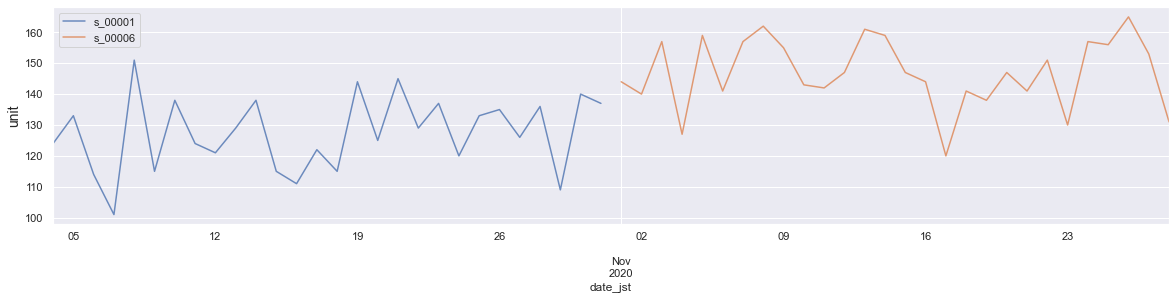

In [37]:
fig, axes = plt.subplots(figsize=(20, 4))
s_00001[['date_jst', 'unit']].set_index('date_jst').resample('D').sum()['unit'].plot(ax=axes, label='s_00001', alpha=0.8).set_ylabel('unit', fontsize=14)
s_00006[['date_jst', 'unit']].set_index('date_jst').resample('D').sum()['unit'].plot(ax=axes, label='s_00006', alpha=0.8).set_ylabel('unit', fontsize=14)
axes.legend()

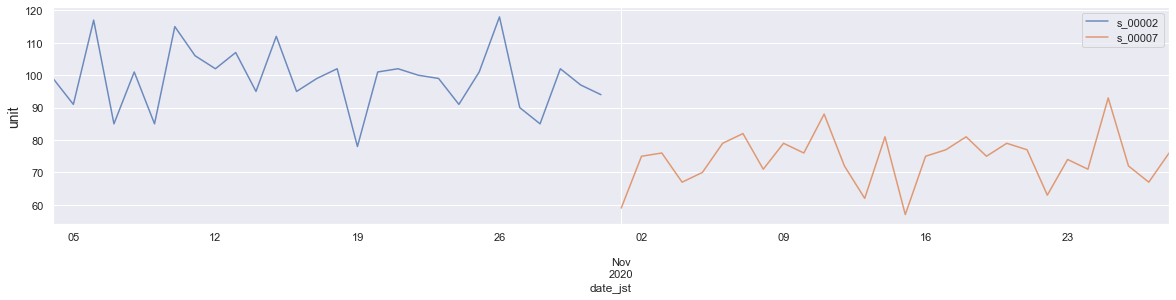

In [38]:
fig, axes = plt.subplots(figsize=(20, 4))
s_00002[['date_jst', 'unit']].set_index('date_jst').resample('D').sum()['unit'].plot(ax=axes, label='s_00002', alpha=0.8).set_ylabel('unit', fontsize=14)
s_00007[['date_jst', 'unit']].set_index('date_jst').resample('D').sum()['unit'].plot(ax=axes, label='s_00007', alpha=0.8).set_ylabel('unit', fontsize=14)
axes.legend()

### ・売上の推移

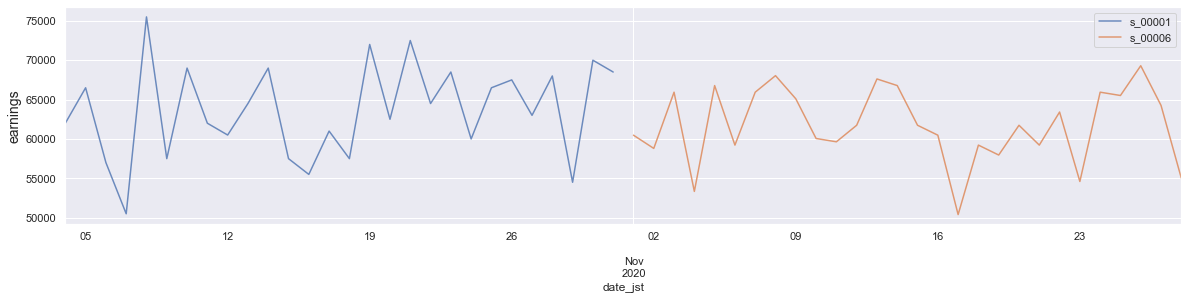

In [39]:
fig, axes = plt.subplots(figsize=(20, 4))
s_00001[['date_jst', 'earnings']].set_index('date_jst').resample('D').sum()['earnings'].plot(ax=axes, label='s_00001', alpha=0.8).set_ylabel('earnings', fontsize=14)
s_00006[['date_jst', 'earnings']].set_index('date_jst').resample('D').sum()['earnings'].plot(ax=axes, label='s_00006', alpha=0.8).set_ylabel('earnings', fontsize=14)
axes.legend()

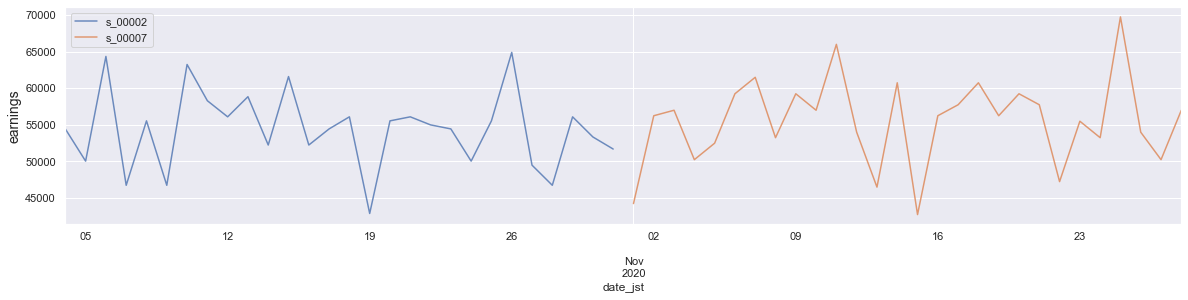

In [40]:
fig, axes = plt.subplots(figsize=(20, 4))
s_00002[['date_jst', 'earnings']].set_index('date_jst').resample('D').sum()['earnings'].plot(ax=axes, label='s_00002', alpha=0.8).set_ylabel('earnings', fontsize=14)
s_00007[['date_jst', 'earnings']].set_index('date_jst').resample('D').sum()['earnings'].plot(ax=axes, label='s_00007', alpha=0.8).set_ylabel('earnings', fontsize=14)
axes.legend()

### ・自己相関

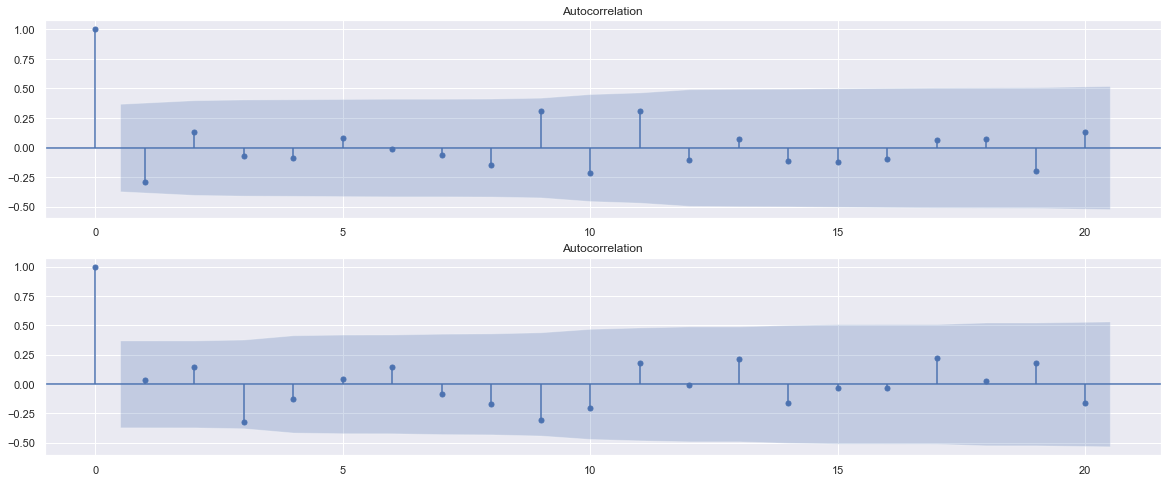

In [41]:
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(s_00001_date['earnings'], lags=20, ax=ax1)

ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(s_00006_date['earnings'], lags=20, ax=ax1)

・s_00001：ラグ3, 9, 14, 18で正の相関が認められ、ラグ3での周期性をもっている<br>
・s_00006：ラグ6, 12, 18で正の相関が認められ、ラグ6での周期性をもっている

・ただし、ほとんどのデータが有意水準5%の棄却限界値を超えていないため、統計的に有意であるとはいえない

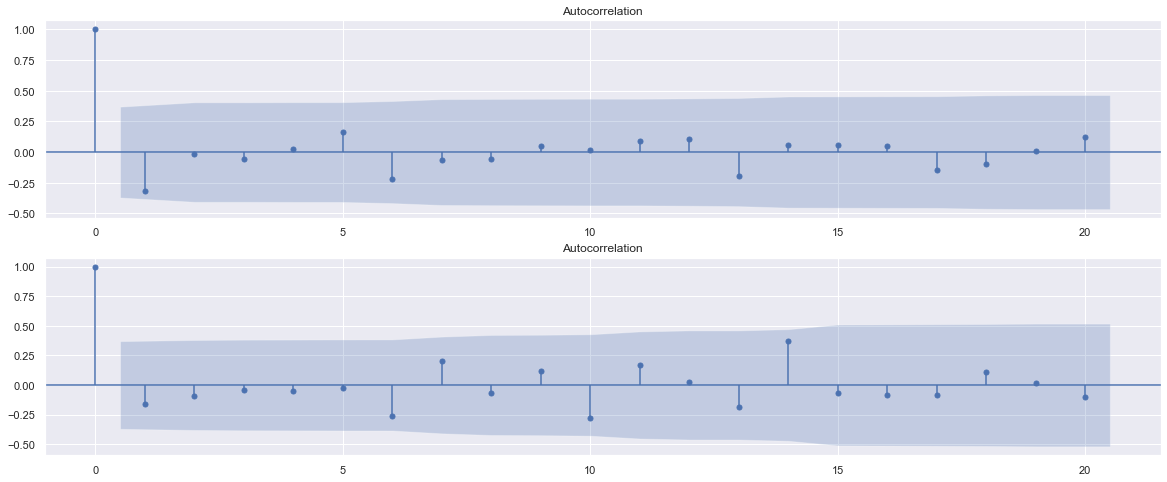

In [42]:
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(s_00002_date['earnings'], lags=20, ax=ax1)

ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(s_00007_date['earnings'], lags=20, ax=ax1)

・s_00002：ラグ4, 8, 12, 16, 20で正の相関が認められ、ラグ4での周期性をもっている<br>
・s_00007：ラグ9, 18で正の相関が認められ、ラグ9での周期性をもっている

・ただし、ほとんどのデータが有意水準5%の棄却限界値を超えていないため、統計的に有意であるとはいえない

## 5. 分析結果

### 5.1 データ集計

In [43]:
group = df.groupby(['item_id']).agg({'unit': 'sum', 'unit_price': 'mean', 'amount': 'mean', 'earnings': 'sum'})

In [44]:
group.loc[['s_00001', 's_00006'], :]

,unit,unit_price,amount,earnings
item_id,,,,
s_00001,3567.0,500,600,1783500.0
s_00006,4115.0,420,500,1728300.0


In [45]:
group.loc[['s_00002', 's_00007'], :]

,unit,unit_price,amount,earnings
item_id,,,,
s_00002,2769.0,550,700,1522950.0
s_00007,2074.0,750,850,1555500.0


In [46]:
group = df.groupby(['renewal']).agg({'unit': 'sum', 'unit_price': 'mean', 'amount': 'mean', 'earnings': 'sum'})

In [47]:
group.loc[[0, 1], :]

,unit,unit_price,amount,earnings
renewal,,,,
0,6336.0,521.851326,643.702652,3306450.0
1,6189.0,530.586524,617.288738,3283800.0


### 5.2 回帰分析

In [48]:
s_00001_date['renewal'] = 0
s_00006_date['renewal'] = 1

In [49]:
jpn = pd.concat([s_00001_date, s_00006_date], axis=0)
jpn['point_card'] = jpn['point_card'] / jpn['unit']

print(jpn.shape)
jpn.head()

(56, 6)


,unit_price,unit,amount,earnings,point_card,renewal
date,,,,,,
2020-10-04,500,124.0,600,62000.0,0.556452,0
2020-10-05,500,133.0,600,66500.0,0.436090,0
2020-10-06,500,114.0,600,57000.0,0.464912,0
2020-10-07,500,101.0,600,50500.0,0.603960,0
2020-10-08,500,151.0,600,75500.0,0.503311,0


・earningは、unitとunit_priceの積なので、その2つを特徴量に入れるとリーク（過学習）になってしまう

In [50]:
jpn_x = jpn[['amount', 'point_card', 'renewal']]
jpn_y = jpn['earnings']

In [51]:
std = StandardScaler()
jpn_x = std.fit_transform(jpn_x)

In [52]:
linreg = LinearRegression()
linreg.fit(jpn_x, jpn_y)

LinearRegression()

In [53]:
print(linreg.coef_)
print(linreg.score(jpn_x, jpn_y))

[ 494.64997731 -549.11694527 -494.64997731]
0.042573854956169055


In [54]:
pd.DataFrame(linreg.coef_, index=['amount', 'point_card', 'renewal'], columns=['coefficient'])

,coefficient
amount,494.649977
point_card,-549.116945
renewal,-494.649977


In [55]:
ridge = Ridge()
ridge.fit(jpn_x, jpn_y)

Ridge()

In [56]:
print(ridge.coef_)
print(ridge.score(jpn_x, jpn_y))

[ 490.24118593 -539.42674701 -490.24118593]
0.0425681523391056


In [57]:
pd.DataFrame(ridge.coef_, index=['amount', 'point_card', 'renewal'], columns=['coefficient'])

,coefficient
amount,490.241186
point_card,-539.426747
renewal,-490.241186


In [58]:
s_00002_date['renewal'] = 0
s_00007_date['renewal'] = 1

In [59]:
wsn = pd.concat([s_00002_date, s_00007_date], axis=0)
wsn['point_card'] = wsn['point_card'] / wsn['unit']

print(wsn.shape)
wsn.head()

(56, 6)


,unit_price,unit,amount,earnings,point_card,renewal
date,,,,,,
2020-10-04,550,99.0,700,54450.0,0.505051,0
2020-10-05,550,91.0,700,50050.0,0.428571,0
2020-10-06,550,117.0,700,64350.0,0.495726,0
2020-10-07,550,85.0,700,46750.0,0.482353,0
2020-10-08,550,101.0,700,55550.0,0.504950,0


In [60]:
wsn_x = wsn[['amount', 'point_card', 'renewal']]
wsn_y = wsn['earnings']

In [61]:
wsn_x = std.fit_transform(wsn_x)

In [62]:
linreg.fit(wsn_x, wsn_y)

LinearRegression()

In [63]:
print(linreg.coef_)
print(linreg.score(wsn_x, wsn_y))

[ 295.49357542 -197.8324018   295.49357542]
0.01186672160063773


In [64]:
pd.DataFrame(linreg.coef_, index=['amount', 'point_card', 'renewal'], columns=['coefficient'])

,coefficient
amount,295.493575
point_card,-197.832402
renewal,295.493575


In [65]:
ridge.fit(wsn_x, wsn_y)

Ridge()

In [66]:
print(ridge.coef_)
print(ridge.score(wsn_x, wsn_y))

[ 292.78754686 -194.09995412  292.78754686]
0.011865423356029137


In [67]:
pd.DataFrame(ridge.coef_, index=['amount', 'point_card', 'renewal'], columns=['coefficient'])

,coefficient
amount,292.787547
point_card,-194.099954
renewal,292.787547


In [68]:
item = pd.concat([jpn, wsn], axis=0)

print(item.shape)
item.head()

(112, 6)


,unit_price,unit,amount,earnings,point_card,renewal
date,,,,,,
2020-10-04,500,124.0,600,62000.0,0.556452,0
2020-10-05,500,133.0,600,66500.0,0.436090,0
2020-10-06,500,114.0,600,57000.0,0.464912,0
2020-10-07,500,101.0,600,50500.0,0.603960,0
2020-10-08,500,151.0,600,75500.0,0.503311,0


In [69]:
item_x = item[['amount', 'point_card', 'renewal']]
item_y = item['earnings']

In [70]:
item_x = std.fit_transform(item_x)

In [71]:
linreg.fit(item_x, item_y)

LinearRegression()

In [72]:
print(linreg.coef_)
print(linreg.score(item_x, item_y))

[-2984.05494235  -376.32790413    95.67390584]
0.20068869336596784


In [73]:
pd.DataFrame(linreg.coef_, index=['amount', 'point_card', 'renewal'], columns=['coefficient'])

,coefficient
amount,-2984.054942
point_card,-376.327904
renewal,95.673906


In [74]:
ridge.fit(item_x, item_y)

Ridge()

In [75]:
print(ridge.coef_)
print(ridge.score(item_x, item_y))

[-2957.41621055  -375.19114414    92.24653814]
0.20067319140285678


In [76]:
pd.DataFrame(ridge.coef_, index=['amount', 'point_card', 'renewal'], columns=['coefficient'])

,coefficient
amount,-2957.416211
point_card,-375.191144
renewal,92.246538


### 5.3 相関関係

In [77]:
jpn.head()

,unit_price,unit,amount,earnings,point_card,renewal
date,,,,,,
2020-10-04,500,124.0,600,62000.0,0.556452,0
2020-10-05,500,133.0,600,66500.0,0.436090,0
2020-10-06,500,114.0,600,57000.0,0.464912,0
2020-10-07,500,101.0,600,50500.0,0.603960,0
2020-10-08,500,151.0,600,75500.0,0.503311,0


<AxesSubplot:>

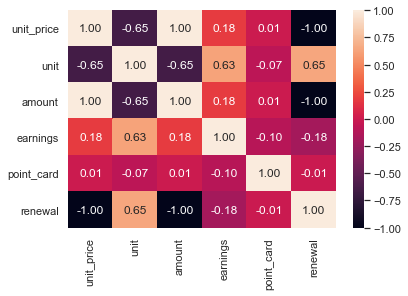

In [78]:
sns.heatmap(jpn.corr(), annot=True, fmt='.2f')

In [79]:
wsn.head()

,unit_price,unit,amount,earnings,point_card,renewal
date,,,,,,
2020-10-04,550,99.0,700,54450.0,0.505051,0
2020-10-05,550,91.0,700,50050.0,0.428571,0
2020-10-06,550,117.0,700,64350.0,0.495726,0
2020-10-07,550,85.0,700,46750.0,0.482353,0
2020-10-08,550,101.0,700,55550.0,0.504950,0


<AxesSubplot:>

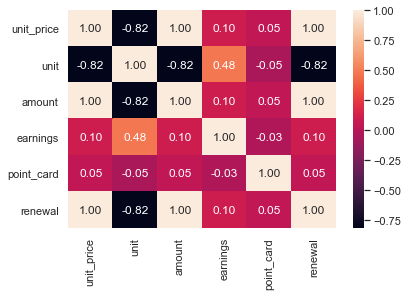

In [80]:
sns.heatmap(wsn.corr(), annot=True, fmt='.2f')

In [81]:
item.head()

,unit_price,unit,amount,earnings,point_card,renewal
date,,,,,,
2020-10-04,500,124.0,600,62000.0,0.556452,0
2020-10-05,500,133.0,600,66500.0,0.436090,0
2020-10-06,500,114.0,600,57000.0,0.464912,0
2020-10-07,500,101.0,600,50500.0,0.603960,0
2020-10-08,500,151.0,600,75500.0,0.503311,0


<AxesSubplot:>

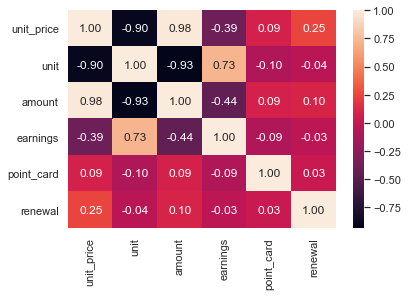

In [82]:
sns.heatmap(item.corr(), annot=True, fmt='.2f')

### 5.4 母平均の差の検定

・母分散が未知のときの母平均の差を検定を行う

In [83]:
s_00001_date.head()

,unit_price,unit,amount,earnings,point_card,renewal
date,,,,,,
2020-10-04,500,124.0,600,62000.0,69,0
2020-10-05,500,133.0,600,66500.0,58,0
2020-10-06,500,114.0,600,57000.0,53,0
2020-10-07,500,101.0,600,50500.0,61,0
2020-10-08,500,151.0,600,75500.0,76,0


In [84]:
s_00006_date.head()

,unit_price,unit,amount,earnings,point_card,renewal
date,,,,,,
2020-11-01,420,144.0,500,60480.0,76,1
2020-11-02,420,140.0,500,58800.0,77,1
2020-11-03,420,157.0,500,65940.0,84,1
2020-11-04,420,127.0,500,53340.0,66,1
2020-11-05,420,159.0,500,66780.0,83,1


In [85]:
print(s_00001_date['earnings'].mean())
print(s_00006_date['earnings'].mean())

63696.42857142857
61725.0


・有意水準：$0.05$<br>
・帰無仮説$H_{0}$：$\mu_{x} = \mu_{y}$<br>
・対立仮説$H_{1}$：$\mu_{x} > \mu_{y}$

・母平均の差の検定で使用する不偏分散は、以下の式で表される

$${S_{XY}}^2 = \frac{1}{m + n - 2}\{\sum_{i=1}^{m}(X_{i} - \bar{X})^{2} + \sum_{i=1}^{n}(Y_{i} - \bar{Y})^{2}    \}$$

$$= \frac{1}{m + n - 2}\{m \cdot \frac{1}{m}\sum_{i=1}^{m}(X_{i} - \bar{X})^{2} + n \cdot \frac{1}{n} \sum_{i=1}^{n}(Y_{i} - \bar{Y})^{2}    \}$$

$$= \frac{1}{m + n - 2}\{m \cdot \sigma_{X}^{2} + n \cdot \sigma_{Y}^{2}   \}$$

<br>

・統計検定量は、次の式で表される

$$ T = \frac{\bar{X} - \bar{Y}}{\sqrt{(\frac{1}{m}+\frac{1}{n}){S_{xy}}^2}}$$

In [86]:
a=0.05
sta, p = stats.ttest_rel(s_00001_date['earnings'], s_00006_date['earnings'], alternative='greater')

print('統計検定量:', round(sta, 2))
print('P値:', round(p, 2))

統計検定量: 1.32
P値: 0.1


In [87]:
if p < a:
    print('結果： 帰無仮説は棄却され、母平均Yの方が小さいといえる')
else:
    print('結果： 帰無仮説は棄却されず、母平均Yの方が小さいとはいえない')

結果： 帰無仮説は棄却されず、母平均Yの方が小さいとはいえない


In [88]:
s_0000２_date.head()

,unit_price,unit,amount,earnings,point_card,renewal
date,,,,,,
2020-10-04,550,99.0,700,54450.0,50,0
2020-10-05,550,91.0,700,50050.0,39,0
2020-10-06,550,117.0,700,64350.0,58,0
2020-10-07,550,85.0,700,46750.0,41,0
2020-10-08,550,101.0,700,55550.0,51,0


In [89]:
s_00007_date.head()

,unit_price,unit,amount,earnings,point_card,renewal
date,,,,,,
2020-11-01,750,59.0,850,44250.0,30,1
2020-11-02,750,75.0,850,56250.0,45,1
2020-11-03,750,76.0,850,57000.0,41,1
2020-11-04,750,67.0,850,50250.0,43,1
2020-11-05,750,70.0,850,52500.0,36,1


In [90]:
print(s_00002_date['earnings'].mean())
print(s_00007_date['earnings'].mean())

54391.07142857143
55553.57142857143


・有意水準：$0.05$<br>
・帰無仮説$H_{0}$：$\mu_{x} = \mu_{y}$<br>
・対立仮説$H_{1}$：$\mu_{x} < \mu_{y}$

In [91]:
sta, p = stats.ttest_rel(s_00002_date['earnings'], s_00007_date['earnings'], alternative='less')

print('統計検定量:', round(sta, 2))
print('P値:', round(p, 2))

統計検定量: -0.73
P値: 0.24


In [92]:
if p < a:
    print('結果： 帰無仮説は棄却され、母平均Yの方が大きいといえる')
else:
    print('結果： 帰無仮説は棄却されず、母平均Yの方が大きいとはいえない')

結果： 帰無仮説は棄却されず、母平均Yの方が大きいとはいえない


In [93]:
before = pd.concat([s_00001_date, s_00002_date], axis=0)

print(before.shape)
before.head()

(56, 6)


,unit_price,unit,amount,earnings,point_card,renewal
date,,,,,,
2020-10-04,500,124.0,600,62000.0,69,0
2020-10-05,500,133.0,600,66500.0,58,0
2020-10-06,500,114.0,600,57000.0,53,0
2020-10-07,500,101.0,600,50500.0,61,0
2020-10-08,500,151.0,600,75500.0,76,0


In [94]:
after = pd.concat([s_00006_date, s_00007_date], axis=0)

print(after.shape)
after.head()

(56, 6)


,unit_price,unit,amount,earnings,point_card,renewal
date,,,,,,
2020-11-01,420,144.0,500,60480.0,76,1
2020-11-02,420,140.0,500,58800.0,77,1
2020-11-03,420,157.0,500,65940.0,84,1
2020-11-04,420,127.0,500,53340.0,66,1
2020-11-05,420,159.0,500,66780.0,83,1


In [95]:
print(before['earnings'].mean())
print(after['earnings'].mean())

59043.75
58639.28571428572


・有意水準：$0.05$<br>
・帰無仮説$H_{0}$：$\mu_{x} = \mu_{y}$<br>
・対立仮説$H_{1}$：$\mu_{x} > \mu_{y}$

In [96]:
sta, p = stats.ttest_rel(before['earnings'], after['earnings'], alternative='greater')

print('統計検定量:', round(sta, 2))
print('P値:', round(p, 2))

統計検定量: 0.37
P値: 0.36


In [97]:
if p < a:
    print('結果： 帰無仮説は棄却され、母平均Yの方が小さいといえる')
else:
    print('結果： 帰無仮説は棄却されず、母平均Yの方が小さいとはいえない')

結果： 帰無仮説は棄却されず、母平均Yの方が小さいとはいえない


・これらの検定結果から、リニューアル前と後で、母平均の差があるとはいえないことが分かる<br>
　つまり、今回のサンプルを得た期間（10/4〜11/28）では多少効果があったかもしれないが、それはたまたまであった可能性があるともいえる

### 5.5 独立性の検定

・有意水準：$0.05$<br>
・帰無仮説$H_{0}$：リニューアルと購入人数は、独立である<br>
・対立仮説$H_{1}$：リニューアルと購入人数には、関連がある

In [98]:
print(df[df['renewal'] == 0]['user_id'].nunique())
print(df[df['renewal'] == 1]['user_id'].nunique())

1415
1356


In [99]:
print(s_00001['user_id'].nunique())
print(s_00006['user_id'].nunique())

print(df[df['renewal'] == 0]['user_id'].nunique() - s_00001['user_id'].nunique())
print(df[df['renewal'] == 1]['user_id'].nunique() - s_00006['user_id'].nunique())

813
813
602
543


In [100]:
data = pd.DataFrame([[814, 602], [813, 543]], index=['s_00001', 's_00006'], columns=['購入した人', '購入しなかった人'])
data.head()

,購入した人,購入しなかった人
s_00001,814,602
s_00006,813,543


In [101]:
chi2, p, dof, expected = stats.chi2_contingency(data)
pd.DataFrame(expected, index=['s_00001', 's_00006'], columns=['購入した人', '購入しなかった人'])

,購入した人,購入しなかった人
s_00001,831.108225,584.891775
s_00006,795.891775,560.108225


In [102]:
print('カイニ乗値：', round(chi2, 2))
print( 'P値：', round(p, 2))
print('自由度:', dof)

カイニ乗値： 1.64
P値： 0.2
自由度: 1


In [103]:
if p < a:
    print('結果： 帰無仮説は棄却され、リニューアルと購入人数には関連がある')
else:
    print('結果： 帰無仮説は棄却されず、リニューアルと購入人数には関連があるとはいえない')

結果： 帰無仮説は棄却されず、リニューアルと購入人数には関連があるとはいえない


In [104]:
print(s_00002['user_id'].nunique())
print(s_00007['user_id'].nunique())

print(df[df['renewal'] == 0]['user_id'].nunique() - s_00002['user_id'].nunique())
print(df[df['renewal'] == 1]['user_id'].nunique() - s_00007['user_id'].nunique())

603
544
812
812


In [105]:
data = pd.DataFrame([[603, 812], [544, 812]], index=['s_00002', 's_00007'], columns=['購入した人', '購入しなかった人'])
data.head()

,購入した人,購入しなかった人
s_00002,603,812
s_00007,544,812


In [106]:
chi2, p, dof, expected = stats.chi2_contingency(data)
pd.DataFrame(expected, index=['s_00002', 's_00007'], columns=['購入した人', '購入しなかった人'])

,購入した人,購入しなかった人
s_00002,585.710935,829.289065
s_00007,561.289065,794.710935


In [107]:
print('カイニ乗値：', round(chi2, 2))
print( 'P値：', round(p, 2))
print('自由度:', dof)

カイニ乗値： 1.68
P値： 0.2
自由度: 1


In [108]:
if p < a:
    print('結果： 帰無仮説は棄却され、リニューアルと購入人数には関連がある')
else:
    print('結果： 帰無仮説は棄却されず、リニューアルと購入人数には関連があるとはいえない')

結果： 帰無仮説は棄却されず、リニューアルと購入人数には関連があるとはいえない


・和風弁当と洋風弁当において、リニューアルと購入人数は、関連があるとはいえないことが分かる

## 6. 結論

和風弁当<br>
・購入個数： 増加した<br>
・売上： 減少した<br>
・考察： 売上が下がったため、リニューアルをしない方がよかったと考えられる

洋風弁当<br>
・購入個数： 減少した<br>
・売上： 増加した<br>
・考察： 売上が上がったため、リニューアルをしてよかったと考えらえる

全体（和風・洋風）<br>
・購入個数： 減少した<br>
・売上： 減少した<br>
・考察： 購入個数も売上も下がったため、リニューアルしない方がよかったと考えられる<br>